# Assignment 2 specification

The purpose of this assignment is to analyse the Bike Sharing Dataset hosted on the UCI repository of datasets.

The dataset is provided with this notebook as a zip file.

There are two related datasets in the zip file: one aggregated by day, and the other aggregated by hour.

They represent the number of bikes that were shared/hired in Washington over that time period, together with the factors that are believed to predict the demand for such bikes.

They include the time unit and various measures of the weather etc. (in terms of temperature, humidity and wind-speed). More description can be found [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset).

You are asked to

1. Read the _hourly_ data and split into training and test data __[5 marks]__
2. For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model __[15 marks]__
3. Using a forward selection approach, build a regression model that offers the best performance, using a machine learning measure (prediction accuracy on the test data) __[30 marks]__
   - You need to pay particular attention to the regression model assumptions
   - For best performance, you will also need to perform feature engineering
     - modifying the existing features
     - transforming them
     - merging them
     - keeping feature correlation as low as possible
   - 10-fold cross-validation should be used to estimate the uncertainty in the fitted model parameters.
4. Which of the 3 target columns is easiest to predict accurately? __[5 marks]__
5. Using this "preferred target", derive a new target whose values are the grouped label (taking the values `Q1`, `Q2`, `Q3`, `Q4`) for demand in the quartiles (0 < demand <= 25th percentile of demand), (25th percentile of demand < demand <= 50th percentile of demand), .. You might find the [pandas quantile calculator](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.quantile.html) convenient when computing the quartile end points (25th, 50th and 75th percentiles), and pandas filtering by rows  convenient for assigning the new labels. __[5 marks]__
6. Use _two_ classification procedures to predict these demand quartiles, repeating the forward selection procedure to find the best model for each, but this time focusing on classification accuracy on the test set as the measure of performance. Are the same features used in each of the two models? __[35 marks]__
7. Which of the two machine learning procedures (regression and classification) provides the highest prediction accuracy on the test set? Why is this? __[5 marks]__

# Task 1: Read the _hourly_ data and split into training and test data.

##Start of Answer 1##

#### Note: mlxtend library is needed for Task 3 and Task 4. Please make sure that you have mlxtend package installed on your conda environment, if not, please make sure to install to run the code in the Tasks mentioned above

#### Plese run the cell below before running any other cells

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import pingouin as pg

C:\Users\USER\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


The first thing I did was reading the data.

To do that I had to load the data from the CSV file.

In [2]:
data = pd.read_csv("hour.csv", index_col=0) 

I then looked at the shape of the data to know how many rows and columns it includes

In [3]:
data.shape

(17379, 16)

As seen above, we found out that the dataframe includes 17379 rows and 16 columns

The second thing I did is having a look at the columns names

In [4]:
data.columns

Index(['dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

As seen above, I was able to list the names of the columns of the dataframe

I then decided to have a look at the first few rows of the dataframe

In [5]:
data.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [6]:
data.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


I then decided to have a look at the deescribtion of the dataframe

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17379 entries, 1 to 17379
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      17379 non-null  object 
 1   season      17379 non-null  int64  
 2   yr          17379 non-null  int64  
 3   mnth        17379 non-null  int64  
 4   hr          17379 non-null  int64  
 5   holiday     17379 non-null  int64  
 6   weekday     17379 non-null  int64  
 7   workingday  17379 non-null  int64  
 8   weathersit  17379 non-null  int64  
 9   temp        17379 non-null  float64
 10  atemp       17379 non-null  float64
 11  hum         17379 non-null  float64
 12  windspeed   17379 non-null  float64
 13  casual      17379 non-null  int64  
 14  registered  17379 non-null  int64  
 15  cnt         17379 non-null  int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 2.3+ MB


I also wanted to know what are the data types of the columns

I found out that all columns are numeric except for the dteday column

After gathering enough information about the data frame I decided to start the data splitting process as follows:

In [8]:
# https://builtin.com/data-science/train-test-split

features = [i for i in data.columns]
targets = []
for i in features:
    if i == 'cnt' or i == 'registered' or i == 'casual':
        targets.append(i)
features.remove('cnt')
features.remove('registered')
features.remove('casual')
features.remove('dteday')
X = data.loc[:, features]
y = data.loc[:, targets]

As seen above, The first thing I did was to create a copy of the dataframe called 'features' without the the columns that I want to use a target which is in this case 'cnt', 'registered' and 'casual'

I also decided to ignore the column 'dteday' because it is the only column that its values are not numeric, also because there are other columns that resemble the same values that this column has such as 'yr' and 'mnth'

I then created a variable called X which holds the columns and values of 'features' and a variable called y which hold the column 'cnt' and its values

In [9]:
# https://builtin.com/data-science/train-test-split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

I then decided to split X and Y, X was splitted into X_train which is the training data of X and X_test which is the testing data of X

y was splitted into y_train which is the training data of y and y_test which is the testing data of y

Traning data was chosen randomly by the train_test_split() function and it makes 75% of the size of the dataframes X and y

The training data will later be used for EDA and to train the regression model

In [10]:
X_test.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
instant,,,,,,,,,,,,
3440,2,0,5,5,0,6,0,1,0.56,0.5303,0.88,0.2239
6543,4,0,10,4,0,3,1,1,0.44,0.4394,0.88,0.0000
15471,4,1,10,19,0,4,1,1,0.44,0.4394,0.51,0.1343
9852,1,1,2,11,1,1,0,1,0.26,0.2273,0.48,0.3582
12641,2,1,6,21,0,5,1,1,0.66,0.6212,0.50,0.1045


In [11]:
y_test.head()

,casual,registered,cnt
instant,,,
3440,4,3,7
6543,1,4,5
15471,81,662,743
9852,45,163,208
12641,83,250,333


In [12]:
X_train.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
instant,,,,,,,,,,,,
7241,4,0,11,7,0,4,1,2,0.32,0.3333,0.81,0.0896
1403,1,0,3,17,0,4,1,1,0.26,0.3030,0.22,0.0000
12148,2,1,5,8,0,6,0,1,0.64,0.5909,0.78,0.1343
3369,2,0,5,6,0,3,1,1,0.56,0.5303,0.94,0.0896
15653,4,1,10,9,0,5,1,2,0.54,0.5152,0.94,0.1045


In [13]:
y_train.head()

,casual,registered,cnt
instant,,,
7241,12,280,292
1403,17,185,202
12148,38,103,141
3369,4,113,117
15653,26,363,389


In [14]:
X_train.count()[0]

13034

The count of rows in the training data is 13034

In [15]:
X_test.count()[0]

4345

The count of rows in the test data is 4345

##End of Answer 1##

# Task 2: For the training data only, use exploratory data analysis to learn about the data and to indicate how to build a model

##Start of Answer 2##

##### Pass 1:

I then decided to start doing EDA on the training data which includes the data frames X_train and y_train

In [16]:
X_train.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
instant,,,,,,,,,,,,
7241,4,0,11,7,0,4,1,2,0.32,0.3333,0.81,0.0896
1403,1,0,3,17,0,4,1,1,0.26,0.3030,0.22,0.0000
12148,2,1,5,8,0,6,0,1,0.64,0.5909,0.78,0.1343
3369,2,0,5,6,0,3,1,1,0.56,0.5303,0.94,0.0896
15653,4,1,10,9,0,5,1,2,0.54,0.5152,0.94,0.1045


The first thing I did is that I renamed the columns and gave them more clearer names and made the first letter of every name a big letter

I did this to make the column names more understandable

In [17]:
X_train.rename(
    columns={ 
        'dteday': 'Date',
        'season': 'Season',
        'yr': 'Year',
        'mnth': 'Month',
        'hr': 'Hour',
        'holiday': 'Holiday',
        'weekday': 'Week_day',
        'workingday':'Working_day',
        'weathersit':'Weather',
        'temp':'Temperature',
        'atemp':'A_Temperature',
        'hum':'Humidity',
        'windspeed':'Wind_speed'
    },
    inplace=True
)

y_train.rename(
    columns={ 
        'registered': 'Registered',
        'casual': 'Casual',
        'cnt':'Count'
    },
    inplace=True
)

X_train.head()
#y_train.head()
#df.head()

,Season,Year,Month,Hour,Holiday,Week_day,Working_day,Weather,Temperature,A_Temperature,Humidity,Wind_speed
instant,,,,,,,,,,,,
7241,4,0,11,7,0,4,1,2,0.32,0.3333,0.81,0.0896
1403,1,0,3,17,0,4,1,1,0.26,0.3030,0.22,0.0000
12148,2,1,5,8,0,6,0,1,0.64,0.5909,0.78,0.1343
3369,2,0,5,6,0,3,1,1,0.56,0.5303,0.94,0.0896
15653,4,1,10,9,0,5,1,2,0.54,0.5152,0.94,0.1045


In [18]:
y_train.head()

,Casual,Registered,Count
instant,,,
7241,12,280,292
1403,17,185,202
12148,38,103,141
3369,4,113,117
15653,26,363,389


I then renamed the columns in the test set as well to make them have the same names as in the training set.

I did this to avoid confusion and errors when building models.

In [19]:
X_test.rename(
    columns={ 
        'dteday': 'Date',
        'season': 'Season',
        'yr': 'Year',
        'mnth': 'Month',
        'hr': 'Hour',
        'holiday': 'Holiday',
        'weekday': 'Week_day',
        'workingday':'Working_day',
        'weathersit':'Weather',
        'temp':'Temperature',
        'atemp':'A_Temperature',
        'hum':'Humidity',
        'windspeed':'Wind_speed'
    },
    inplace=True
)

y_test.rename(
    columns={ 
        'registered': 'Registered',
        'casual': 'Casual',
        'cnt':'Count'
    },
    inplace=True
)

X_test.head()

,Season,Year,Month,Hour,Holiday,Week_day,Working_day,Weather,Temperature,A_Temperature,Humidity,Wind_speed
instant,,,,,,,,,,,,
3440,2,0,5,5,0,6,0,1,0.56,0.5303,0.88,0.2239
6543,4,0,10,4,0,3,1,1,0.44,0.4394,0.88,0.0000
15471,4,1,10,19,0,4,1,1,0.44,0.4394,0.51,0.1343
9852,1,1,2,11,1,1,0,1,0.26,0.2273,0.48,0.3582
12641,2,1,6,21,0,5,1,1,0.66,0.6212,0.50,0.1045


In [20]:
y_test.head()

,Casual,Registered,Count
instant,,,
3440,4,3,7
6543,1,4,5
15471,81,662,743
9852,45,163,208
12641,83,250,333


I then decided to sort all the rows based on the index

In [21]:
X_train.sort_index(inplace=True)
y_train.sort_index(inplace=True)

X_train.head()
#y_train.head()

,Season,Year,Month,Hour,Holiday,Week_day,Working_day,Weather,Temperature,A_Temperature,Humidity,Wind_speed
instant,,,,,,,,,,,,
1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0
2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0
3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0
4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0
5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0


In [22]:
X_train.isnull().values.any()

False

In [23]:
y_train.isnull().values.any()

False

##### Pass 2:

The first thing I did was creating a temporary dataset called Xy_train which joins both X_train and y_train

The reason for that is to enable me to do EDA on both datasets at the same time and compare between their columns

In [24]:
Xy_train = X_train
Xy_train = Xy_train.join(y_train['Casual'])
Xy_train = Xy_train.join(y_train['Registered'])
Xy_train = Xy_train.join(y_train['Count'])
Xy_train.head()

,Season,Year,Month,Hour,Holiday,Week_day,Working_day,Weather,Temperature,A_Temperature,Humidity,Wind_speed,Casual,Registered,Count
instant,,,,,,,,,,,,,,,
1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


The first thing I did was looking at the count of each season

<AxesSubplot:xlabel='Season', ylabel='count'>

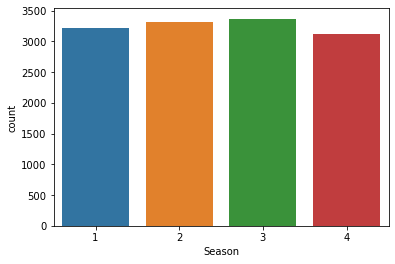

In [25]:
sns.countplot(x="Season", data=Xy_train)

As seen above, season 3 has the greatest count and season 4 has the smallest count

I then looked at the count of every year

<AxesSubplot:xlabel='Year', ylabel='count'>

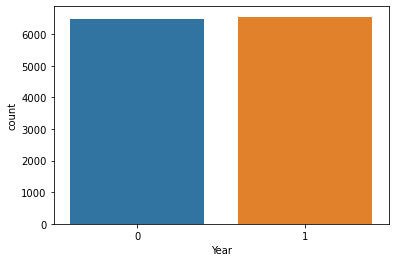

In [26]:
sns.countplot(x="Year", data=Xy_train)

As seen above, year 1 has the greatest count

I then looked at the count of every month

<AxesSubplot:xlabel='Month', ylabel='count'>

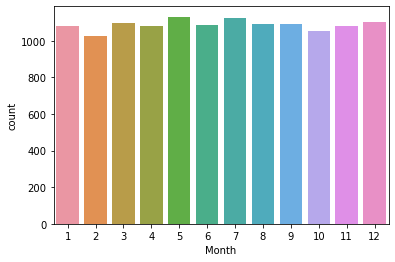

In [27]:
sns.countplot(x="Month", data=Xy_train)

As seen above, months 5 and 7 has the greatest count and month 2 has the smallest count

I then looked at the count of every hour

<AxesSubplot:xlabel='Hour', ylabel='count'>

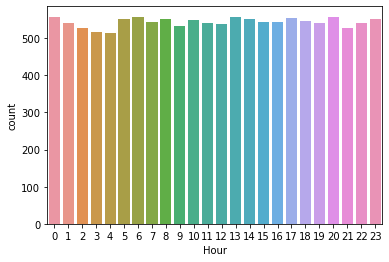

In [28]:
sns.countplot(x="Hour", data=Xy_train)

As seen above, hours 6 and 13, 20 has the greatest count and hour 4 has the smallest count

I then looked at the count of every holiday

<AxesSubplot:xlabel='Holiday', ylabel='count'>

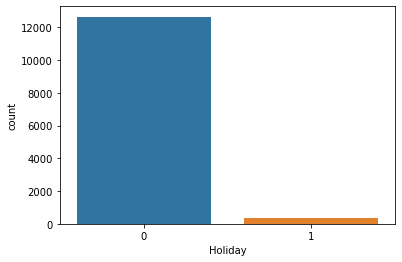

In [29]:
sns.countplot(x="Holiday", data=Xy_train)

As seen above, holiday 0 has the greatest count

I then looked at the count of every week day

<AxesSubplot:xlabel='Week_day', ylabel='count'>

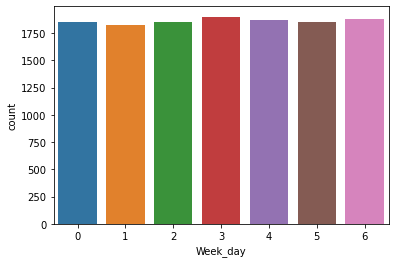

In [30]:
sns.countplot(x="Week_day", data=Xy_train)

As seen above, week day 3 has the greatest count and week day 1 has the smallest count

I then looked at the count of working day

<AxesSubplot:xlabel='Working_day', ylabel='count'>

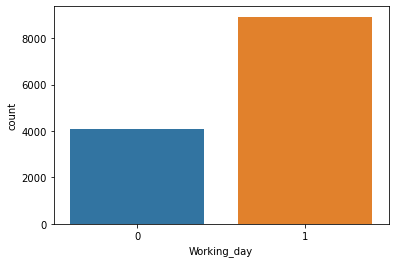

In [31]:
sns.countplot(x="Working_day", data=Xy_train)

As seen above, working day 1 has the greatest count

I then looked at the count of every weather

<AxesSubplot:xlabel='Weather', ylabel='count'>

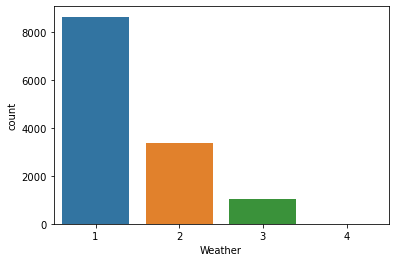

In [32]:
sns.countplot(x="Weather", data=Xy_train)

As seen above, weather 1 has the greatest count and weather 4 has the smallest count

I then looked at the count of every week day based on the season

<AxesSubplot:xlabel='Week_day', ylabel='Count'>

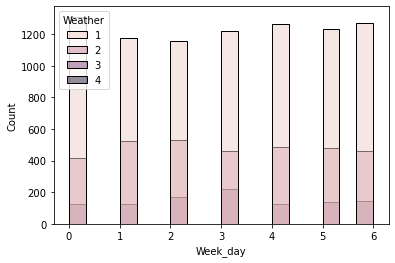

In [33]:
sns.histplot(data=Xy_train, x='Week_day', hue="Weather")

As seen above, week day 0 has the greatest count over all and based on weather it has the greatest count in weather 1

I then looked at the count of every month based on the weather

<AxesSubplot:xlabel='Month', ylabel='Count'>

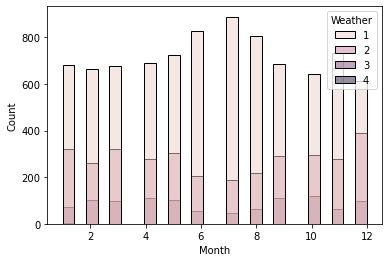

In [34]:
sns.histplot(data=Xy_train, x='Month', hue="Weather")

As seen above, month 7 has the greatest count over all and based on weather it has the greatest count in weather 1

I then looked at the count of every hour based on the weather

<AxesSubplot:xlabel='Hour', ylabel='Count'>

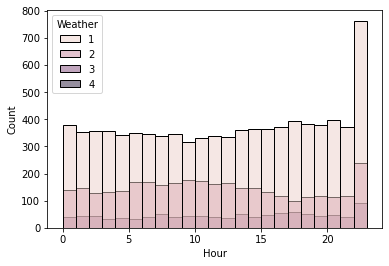

In [35]:
sns.histplot(data=Xy_train, x='Hour', hue="Weather")

As seen above, hour 23 has the greatest count over all and based on weather it has the greatest count in weather 1

I then created a boxplot to visualize casual target

<AxesSubplot:xlabel='Casual'>

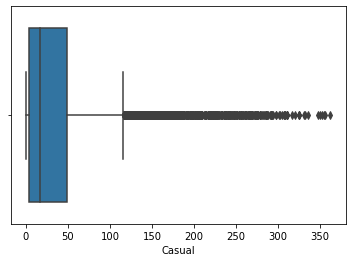

In [36]:
sns.boxplot(x="Casual", data=Xy_train)

As seen above, the target casual has a lot of layouts

Its greatest value is over 350 and its lowest value is almost 0

Its median is about 15

I then created a boxplot to visualize registered target

<AxesSubplot:xlabel='Registered'>

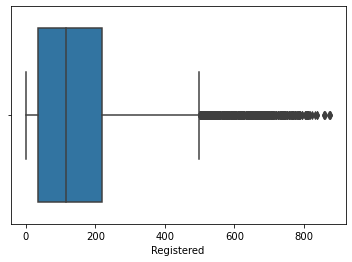

In [37]:
sns.boxplot(x="Registered", data=Xy_train)

As seen above, the target registered has a lot of layouts

Its greatest value is over 800 and its lowest value is almost 0

Its median is about 100

I then created a boxplot to visualize count target

<AxesSubplot:xlabel='Count'>

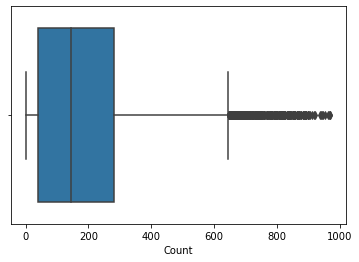

In [38]:
sns.boxplot(x="Count", data=Xy_train)

As seen above, the target count has a lot of layouts

Its greatest value is almost 1000 and its lowest value is almost 0

Its median is about 150

#### Pass 3:

The first thing I decided to do is to do a pairplot to check the relations between targets with each other, targets with some features and features with each other

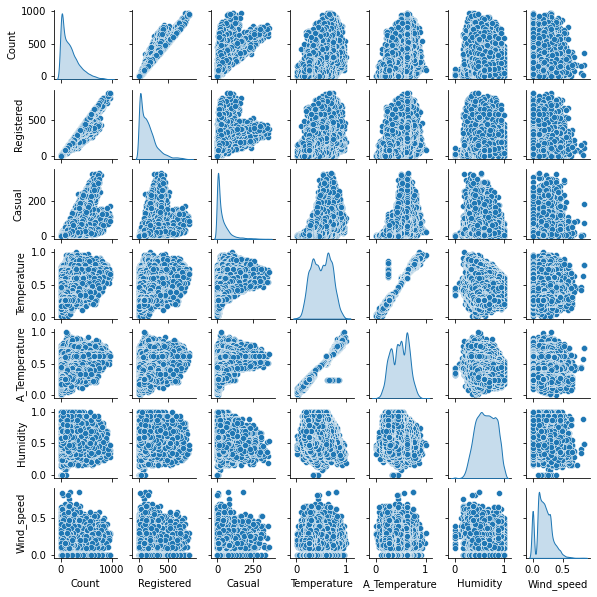

In [39]:
sns.pairplot(data=Xy_train[["Count", 'Registered', 'Casual', "Temperature", "A_Temperature", "Humidity", "Wind_speed"]], 
             diag_kind="kde", height=1.2)

As seen above, There is a high correlation between the following targets:

- Registerd and Count

- Casual and Count 

- Registered and Casual

The following features:

- Temperature and A_Temperature

We can also notice that the correlation between Casual and the other two targets doesn't look normal

We can also see that the correlation between the targets and the other features is either normal or weak

But I will be displaying those correlations in a line plot to get a better understanding of them

I first decided to create a line plot to compare between the features A_Temperature with Temperature

<AxesSubplot:xlabel='Temperature', ylabel='A_Temperature'>

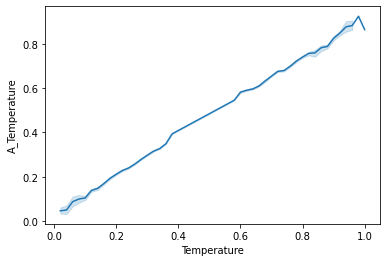

In [40]:
sns.lineplot(data=Xy_train, x="Temperature", y="A_Temperature")
#Xy_train.head()

As seen above, there is a high correlation between the two features

I then decided to compare between the targets Registered and Casual with a lineplot

<AxesSubplot:xlabel='Casual', ylabel='Registered'>

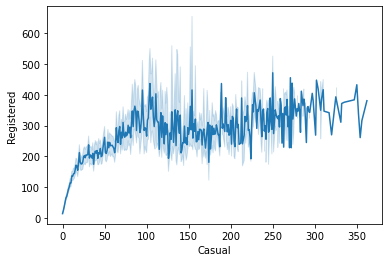

In [41]:
sns.lineplot(data=Xy_train, x="Casual", y="Registered")

As seen above, There is a high correlation between Casual and Register

However, the line is unstable

This explains why the scatter plot comparing between Casual and Registered in the pairplot looked abnormal

I then decided to compare target Count and the target Casual with a lineplot

<AxesSubplot:xlabel='Casual', ylabel='Count'>

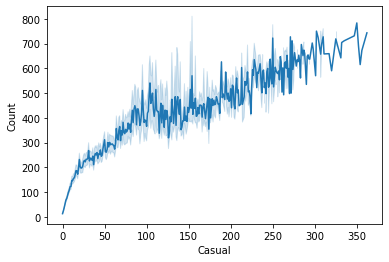

In [42]:
sns.lineplot(data=Xy_train, x="Casual", y="Count")

As seen above, There is a high correlation between Count and Casual

However, the line is unstable

This explains why the scatter plot comparing between Count and Casual in the pairplot looked abnormal

I then decided to compare target Count and the target Register with a lineplot

<AxesSubplot:xlabel='Registered', ylabel='Count'>

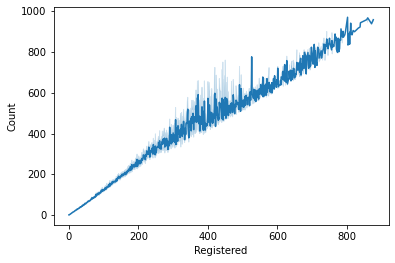

In [43]:
sns.lineplot(data=Xy_train, x="Registered", y="Count")

As seen above, There is a high correlation between Count and Register

I then decided to see if there is any relation between the target Casual and the target Count based on Season using a line plot

<AxesSubplot:xlabel='Casual', ylabel='Count'>

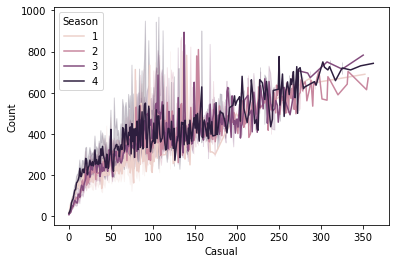

In [44]:
sns.lineplot(data=Xy_train, x="Casual", y="Count", hue="Season")

As seen above, There is a high correlation between Casual and Register

The correlation looks similar for all seasons

I then decided to see if there is any relation between the target Casual and the target Count based on Year using a line plot

<AxesSubplot:xlabel='Casual', ylabel='Count'>

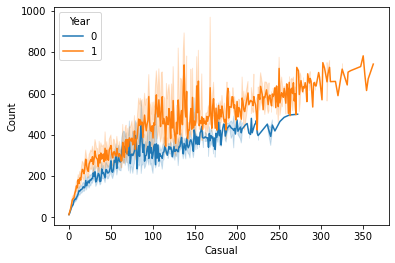

In [45]:
sns.lineplot(data=Xy_train, x="Casual", y="Count", hue="Year")

As seen above, There is a high correlation between Casual and Count

The correlation looks similar for all years

I then decided to compare the feature Humidity and the target Count using a line plot

<AxesSubplot:xlabel='Humidity', ylabel='Count'>

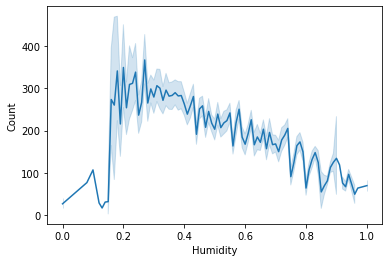

In [46]:
sns.lineplot(data=Xy_train, x="Humidity", y="Count")

As seen above, There is some negative correlation between Casual and Count

I then decided to compare the feature Temperature and the target Count using a line plot

<AxesSubplot:xlabel='Temperature', ylabel='Count'>

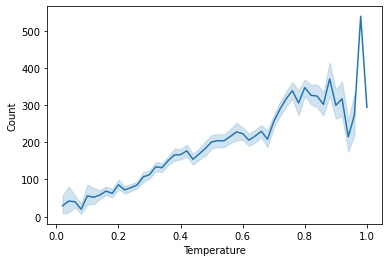

In [47]:
sns.lineplot(data=Xy_train, x="Temperature", y="Count")

As seen above, There is some correlation between Temperature and Count

I then decided to compare the feature A_Temperature and the target Count using a line plot

<AxesSubplot:xlabel='A_Temperature', ylabel='Count'>

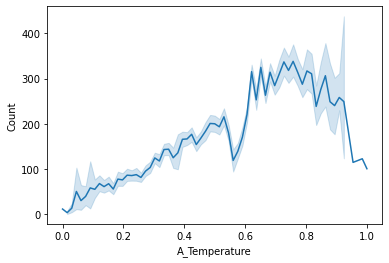

In [48]:
sns.lineplot(data=Xy_train, x="A_Temperature", y="Count")

As seen above, There is some postive and negative correlation between A_Temperature and Count with some spread in the line

I then decided to compare the feature Wind_speed and the target Count using a line plot

<AxesSubplot:xlabel='Wind_speed', ylabel='Count'>

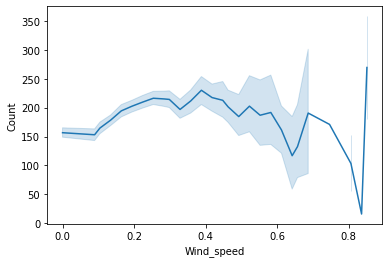

In [49]:
sns.lineplot(data=Xy_train, x="Wind_speed", y="Count")

As seen above, There is some postive and negative correlation between Wind_speed and Count with some spread in the line

I then decided to compare the feature Humidity and the target Registered using a line plot

<AxesSubplot:xlabel='Humidity', ylabel='Registered'>

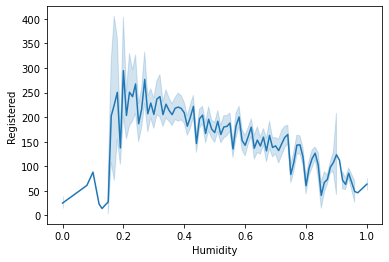

In [50]:
sns.lineplot(data=Xy_train, x="Humidity", y="Registered")

As seen above, There is some postive and negative correlation between Humidity and Registered with some spread in the line

I then decided to compare the feature Temperature and the target Registered using a line plot

<AxesSubplot:xlabel='Temperature', ylabel='Registered'>

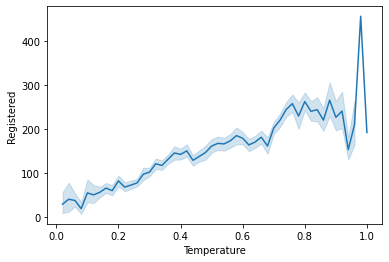

In [51]:
sns.lineplot(data=Xy_train, x="Temperature", y="Registered")

As seen above, There is some correlation between Temperature and Registered

I then decided to compare the feature A_Temperature and the target Registered using a line plot

<AxesSubplot:xlabel='A_Temperature', ylabel='Registered'>

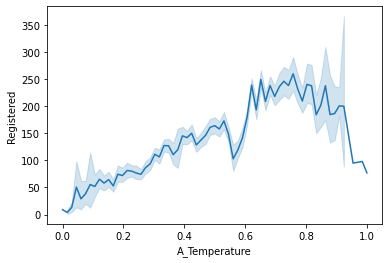

In [52]:
sns.lineplot(data=Xy_train, x="A_Temperature", y="Registered")

As seen above, There is some postive and negative correlation between A_Temperature and Registered with some spread in the line

I then decided to compare the feature Wind_speed and the target Registered using a line plot

<AxesSubplot:xlabel='Wind_speed', ylabel='Registered'>

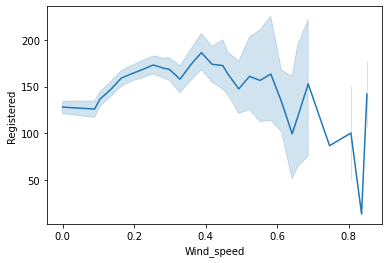

In [53]:
sns.lineplot(data=Xy_train, x="Wind_speed", y="Registered")

As seen above, There is some postive and negative correlation between Wind_speed and Registered with some spread in the line

I then decided to compare the feature Humidity and the target Casual using a line plot

<AxesSubplot:xlabel='Humidity', ylabel='Casual'>

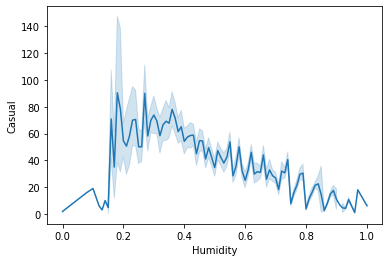

In [54]:
sns.lineplot(data=Xy_train, x="Humidity", y="Casual")

As seen above, There is some postive and negative correlation between Humidity and Casual with some spread in the line

I then decided to compare the feature A_Temperature and the target Casual using a line plot

<AxesSubplot:xlabel='A_Temperature', ylabel='Casual'>

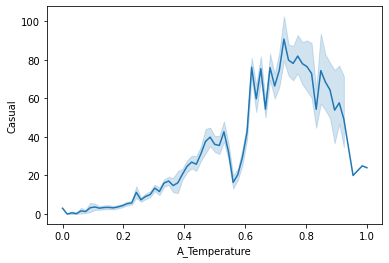

In [55]:
sns.lineplot(data=Xy_train, x="A_Temperature", y="Casual")

As seen above, There is some postive and negative correlation between A_Temperature and Casual with some spread in the line

I then decided to compare the feature Temperature and the target Casual using a line plot

<AxesSubplot:xlabel='Temperature', ylabel='Casual'>

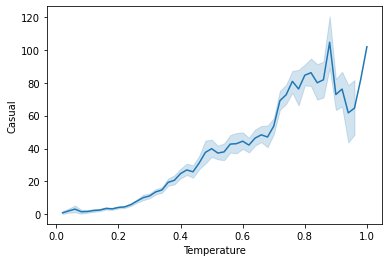

In [56]:
sns.lineplot(data=Xy_train, x="Temperature", y="Casual")

As seen above, There is some positive correlation between Temperature and Casual with some spread in the line

I then decided to compare the feature Wind_speed and the target Casual using a line plot

<AxesSubplot:xlabel='Wind_speed', ylabel='Casual'>

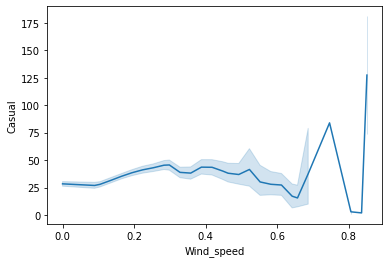

In [57]:
sns.lineplot(data=Xy_train, x="Wind_speed", y="Casual")

As seen above, There is some positive correlation between Wind_speed and Casual with some spread in the line

I then decided to show the correlation between all the features and the targets

In [58]:
Xy_train.corr()

,Season,Year,Month,Hour,Holiday,Week_day,Working_day,Weather,Temperature,A_Temperature,Humidity,Wind_speed,Casual,Registered,Count
Season,1.000000,-0.008557,0.828647,-0.011980,-0.007212,-0.011391,0.014054,-0.019031,0.314827,0.321761,0.148633,-0.144617,0.128122,0.176177,0.181783
Year,-0.008557,1.000000,-0.008727,0.001295,0.008296,-0.003521,-0.002388,-0.016863,0.033881,0.032817,-0.083780,-0.005709,0.138903,0.248363,0.244904
Month,0.828647,-0.008727,1.000000,-0.016063,0.023133,0.005559,-0.003164,0.002693,0.201141,0.206767,0.163549,-0.129357,0.073668,0.122338,0.122064
Hour,-0.011980,0.001295,-0.016063,1.000000,-0.001926,-0.014924,-0.000586,-0.018875,0.143309,0.140415,-0.279288,0.144491,0.303834,0.376337,0.396523
Holiday,-0.007212,0.008296,0.023133,-0.001926,1.000000,-0.101397,-0.255441,-0.022210,-0.023751,-0.026904,-0.008930,-0.002909,0.034300,-0.048485,-0.031083
Week_day,-0.011391,-0.003521,0.005559,-0.014924,-0.101397,1.000000,0.033604,0.000603,-0.006934,-0.013606,-0.039323,0.012745,0.031850,0.019100,0.024599
Working_day,0.014054,-0.002388,-0.003164,-0.000586,-0.255441,0.033604,1.000000,0.044863,0.047772,0.046271,0.022790,-0.014935,-0.309137,0.129600,0.023860
Weather,-0.019031,-0.016863,0.002693,-0.018875,-0.022210,0.000603,0.044863,1.000000,-0.103098,-0.105777,0.416286,0.028407,-0.149754,-0.124300,-0.144422
Temperature,0.314827,0.033881,0.201141,0.143309,-0.023751,-0.006934,0.047772,-0.103098,1.000000,0.987644,-0.071085,-0.018790,0.457506,0.332337,0.401691
A_Temperature,0.321761,0.032817,0.206767,0.140415,-0.026904,-0.013606,0.046271,-0.105777,0.987644,1.000000,-0.054275,-0.057344,0.453185,0.331025,0.399420


Below is the correlation between Casual and all the other targets and features

In [59]:
Xy_train.corr()['Casual']

Season           0.128122
Year             0.138903
Month            0.073668
Hour             0.303834
Holiday          0.034300
Week_day         0.031850
Working_day     -0.309137
Weather         -0.149754
Temperature      0.457506
A_Temperature    0.453185
Humidity        -0.346277
Wind_speed       0.097953
Casual           1.000000
Registered       0.507926
Count            0.695839
Name: Casual, dtype: float64

Below is the correlation between Registered and all the other targets and features

In [60]:
Xy_train.corr()['Registered']

Season           0.176177
Year             0.248363
Month            0.122338
Hour             0.376337
Holiday         -0.048485
Week_day         0.019100
Working_day      0.129600
Weather         -0.124300
Temperature      0.332337
A_Temperature    0.331025
Humidity        -0.271537
Wind_speed       0.089932
Casual           0.507926
Registered       1.000000
Count            0.972091
Name: Registered, dtype: float64

Below is the correlation between Count and all the other targets and features

In [61]:
Xy_train.corr()['Count']

Season           0.181783
Year             0.244904
Month            0.122064
Hour             0.396523
Holiday         -0.031083
Week_day         0.024599
Working_day      0.023860
Weather         -0.144422
Temperature      0.401691
A_Temperature    0.399420
Humidity        -0.320705
Wind_speed       0.101659
Casual           0.695839
Registered       0.972091
Count            1.000000
Name: Count, dtype: float64

I then decided to sort all the correlations between targets and features and targets and themselves

To do that I had to use the absolute value of every correlalation so that strong negative correlation won't be interpreted in a wrong way

In [62]:
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas

Xy_train.corr().abs().unstack().sort_values(kind="quicksort")['Casual']

Week_day         0.031850
Holiday          0.034300
Month            0.073668
Wind_speed       0.097953
Season           0.128122
Year             0.138903
Weather          0.149754
Hour             0.303834
Working_day      0.309137
Humidity         0.346277
A_Temperature    0.453185
Temperature      0.457506
Registered       0.507926
Count            0.695839
Casual           1.000000
dtype: float64

As seen above, The highest correlation for Casual is with Count and the lowest is with Week_day

In [63]:
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
Xy_train.corr().abs().unstack().sort_values(kind="quicksort")['Registered']

Week_day         0.019100
Holiday          0.048485
Wind_speed       0.089932
Month            0.122338
Weather          0.124300
Working_day      0.129600
Season           0.176177
Year             0.248363
Humidity         0.271537
A_Temperature    0.331025
Temperature      0.332337
Hour             0.376337
Casual           0.507926
Count            0.972091
Registered       1.000000
dtype: float64

As seen above, The highest correlation for Registered is with Count and the lowest is with Week_day

In [64]:
# https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas
Xy_train.corr().abs().unstack().sort_values(kind="quicksort")['Count']

Working_day      0.023860
Week_day         0.024599
Holiday          0.031083
Wind_speed       0.101659
Month            0.122064
Weather          0.144422
Season           0.181783
Year             0.244904
Humidity         0.320705
Hour             0.396523
A_Temperature    0.399420
Temperature      0.401691
Casual           0.695839
Registered       0.972091
Count            1.000000
dtype: float64

As seen above, The highest correlation for Count is with Registerd and the lowest is with Working_day

I then decided to get the total of correlations for every target

In [65]:
print('Casual: ' + str(sum(Xy_train.corr().abs().unstack().sort_values(kind="quicksort")['Casual'])))
print('Registered: ' + str(sum(Xy_train.corr().abs().unstack().sort_values(kind="quicksort")['Registered'])))
print('Count: ' + str(sum(Xy_train.corr().abs().unstack().sort_values(kind="quicksort")['Count'])))

Casual: 4.728252503212804
Registered: 4.7495471012276775
Count: 5.060643469727814


As seen above, the highest correlation achieved between a target and other targets and features is for the target Count and the lowest is for the target Casual

##End of Answer 2##

# Task 3: Using a forward selection approach, build a regression model that offers the best performance

##Start of Answer 3##

In [66]:
print(len(X_train.columns))

12


The first thing I did to build the regression model is that I imported a library called  mlxtend

Then I used that library to create the function below with a parameter called target to use the function on multiple targets easiliy and a parameter called verb to change the verbose easily

In [67]:
def modelBuild(target, verb):
    
    # https://www.analyticsvidhya.com/blog/2021/04/forward-feature-selection-and-its-implementation/
    # https://www.youtube.com/watch?v=POCvLGRLDzM&ab_channel=StatsWire
    
    lreg = LinearRegression()

    sfs1 = sfs(lreg, k_features=6, forward=True, verbose=verb, scoring='r2', cv=10)

    sfs1 = sfs1.fit(X_train, y_train[target])

    feat_names = list(sfs1.k_feature_names_)
    print(feat_names)

    return pd.DataFrame.from_dict(sfs1.get_metric_dict()).T

As seen above, we first initialize the linear regression variable

Then we use the Sequential Feature Selector of the mlxtend library and give it the following parameters:
- The model name, in this case the linear regression model
- The amount of features we want to pick as predictors, in my case I picked 6
- We enable forward selection by setting it to True
- We set the verbose parameter to verb to change the amount of information we get from the model summery for each iteration easiliy 
- We set scoring parameter to r2 to base scoring on r2
- we set parameter cv to 10 to have 10 folds cross validation

Now that the model is ready, I fit the model with the training features dataset (X_train) and with the target from the training targets dataframe (y_train)

I then return a pandas dataframe that shows the avarage r2 score of each feature combination

After that I decided to fit the model with the target Casual

In [68]:
modelBuild('Casual', 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.3s finished

[2022-12-09 10:36:20] Features: 1/6 -- score: 0.09223291605917253[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished

[2022-12-09 10:36:20] Features: 2/6 -- score: 0.10871417299119446[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.4s finished

[2022-12-09 10:36:20] Features: 3/6 -- score: 0.1226815013959877[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   

['Holiday', 'Week_day', 'Working_day', 'Weather', 'Temperature', 'A_Temperature']


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished

[2022-12-09 10:36:22] Features: 6/6 -- score: 0.11731310526995234

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[0.11690402295220081, 0.17218294715703675, -0....",0.092233,"(Temperature,)",0.056351,0.075872,0.025291
2,"(6, 8)","[-0.8542076268621124, 0.3487909033040083, 0.05...",0.108714,"(Working_day, Temperature)",0.244117,0.328683,0.109561
3,"(6, 7, 8)","[-0.7710733218959636, 0.3585309339442144, 0.02...",0.122682,"(Working_day, Weather, Temperature)",0.229288,0.308716,0.102905
4,"(4, 6, 7, 8)","[-0.7911620035464766, 0.36425503424318895, 0.0...",0.122985,"(Holiday, Working_day, Weather, Temperature)",0.235053,0.316479,0.105493
5,"(4, 6, 7, 8, 9)","[-0.798180203987733, 0.3642812151444652, -3.48...",0.12062,"(Holiday, Working_day, Weather, Temperature, A...",0.236567,0.318517,0.106172
6,"(4, 5, 6, 7, 8, 9)","[-0.8326726387930183, 0.3604658642912194, -0.0...",0.117313,"(Holiday, Week_day, Working_day, Weather, Temp...",0.244069,0.328618,0.109539


As seen above, the r2 scores for every feature combination of the six features has been shown

We can see that the greatest r2 score has been achieved with the following feature combination: (Holiday, Working_day, Weather, Temperature)

This means that this combination of features is the best choice for predicting the target Casual

I then decided to fit the model with the target Registered

In [69]:
modelBuild('Registered', 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.4s finished

[2022-12-09 10:36:28] Features: 1/6 -- score: -0.09400169874064342[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.6s finished

[2022-12-09 10:36:28] Features: 2/6 -- score: 0.04042016539573352[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished

[2022-12-09 10:36:29] Features: 3/6 -- score: 0.11261318549432664[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

['Season', 'Year', 'Hour', 'Working_day', 'Temperature', 'Humidity']


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished

[2022-12-09 10:36:30] Features: 6/6 -- score: 0.16097751934104249

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[-0.5524313597960953, 0.0645553685037461, -0.4...",-0.094002,"(Temperature,)",0.164444,0.22141,0.073803
2,"(1, 8)","[-0.03130705717707971, 0.18800609359546694, -0...",0.04042,"(Year, Temperature)",0.05752,0.077446,0.025815
3,"(1, 3, 8)","[-0.47892224154861385, 0.27171449579984297, 0....",0.112613,"(Year, Hour, Temperature)",0.153066,0.206091,0.068697
4,"(0, 1, 3, 8)","[-0.5179429673189591, 0.25447819331200505, 0.1...",0.128046,"(Season, Year, Hour, Temperature)",0.161371,0.217273,0.072424
5,"(0, 1, 3, 8, 10)","[-0.5646121953394676, 0.2545157704268074, 0.18...",0.146848,"(Season, Year, Hour, Temperature, Humidity)",0.177596,0.239117,0.079706
6,"(0, 1, 3, 6, 8, 10)","[-0.5834349680216002, 0.2566716471864515, 0.20...",0.160978,"(Season, Year, Hour, Working_day, Temperature,...",0.185151,0.249289,0.083096


As seen above, the r2 scores for every feature combination of the six features has been shown

We can see that the greatest r2 score has been achieved with the following feature combination: (Season, Year, Hour, Working_day, Temperature, Humidity)

This means that this combination of features is the best choice for predicting the target Registered

I then decided to fit the model with the target Count

In [70]:
modelBuild('Count', 2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    0.2s finished

[2022-12-09 10:36:34] Features: 1/6 -- score: -0.04173816546395982[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  11 out of  11 | elapsed:    0.4s finished

[2022-12-09 10:36:35] Features: 2/6 -- score: 0.06355087175913185[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.3s finished

[2022-12-09 10:36:35] Features: 3/6 -- score: 0.13375601466791845[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 

['Season', 'Year', 'Hour', 'Weather', 'Temperature', 'Humidity']


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished

[2022-12-09 10:36:36] Features: 6/6 -- score: 0.1634205360203608

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(8,)","[-0.36472506448436426, 0.1413788272968265, -0....",-0.041738,"(Temperature,)",0.14643,0.197156,0.065719
2,"(1, 8)","[-0.0791745673962394, 0.2275482522800969, -0.0...",0.063551,"(Year, Temperature)",0.068455,0.092169,0.030723
3,"(1, 3, 8)","[-0.6053630561589662, 0.3259663018867821, 0.21...",0.133756,"(Year, Hour, Temperature)",0.190108,0.255965,0.085322
4,"(1, 3, 7, 8)","[-0.5867044421411798, 0.33065000282318, 0.1803...",0.143633,"(Year, Hour, Weather, Temperature)",0.187122,0.251944,0.083981
5,"(0, 1, 3, 7, 8)","[-0.6948757260883469, 0.30772491260635926, 0.2...",0.150684,"(Season, Year, Hour, Weather, Temperature)",0.211112,0.284245,0.094748
6,"(0, 1, 3, 7, 8, 10)","[-0.8519139458062419, 0.3129080523297455, 0.21...",0.163421,"(Season, Year, Hour, Weather, Temperature, Hum...",0.253568,0.341407,0.113802


As seen above, the r2 scores for every feature combination of the six features has been shown

We can see that the greatest r2 score has been achieved with the following feature combination: (Season, Year, Hour, Weather, Temperature, Humidity)

This means that this combination of features is the best choice for predicting the target Count

So now we have successfully build a regression model that fits every target individually with 6 features and produces r2 scores

Now I will try the model against the test set

I decided to see the difference between the first 5 origninal values and the first 5 predicted values

In [71]:
lreg=LinearRegression()

lreg.fit(X_train[['Holiday', 'Working_day', 'Weather', 'Temperature']],y_train['Casual'])

print(lreg.predict(X_test[['Holiday', 'Working_day', 'Weather', 'Temperature']])[0:5])

print(y_test[['Casual']][0:5])

[71.02163396 20.8427623  20.8427623  22.74599985 46.98668881]
         Casual
instant        
3440          4
6543          1
15471        81
9852         45
12641        83


As seen above, there is a big difference between the values, this makes sence because the avarage score of the best features combination to predict Casual which is the one I used above is 0.122985

Then I did the same thing for the other targets

In [72]:
lreg=LinearRegression()

# Train the model using the training sets y_pred=clf.predict(X_test)

lreg.fit(X_train[['Season', 'Year', 'Hour', 'Working_day', 'Temperature', 'Humidity']],y_train['Registered'])

print(lreg.predict(X_test[['Season', 'Year', 'Hour', 'Working_day', 'Temperature', 'Humidity']])[0:5])
print(y_test[['Registered']][0:5])

[ 16.20576153  65.89239931 283.01750421 108.56754852 298.1239762 ]
         Registered
instant            
3440              3
6543              4
15471           662
9852            163
12641           250


The predicted values for Registered look more accurate than the ones for Casual, this is because the avarage score for the combination we used in here is 0.160978 which is greater than the avarage score for the combination used to predict Casual

In [73]:
lreg=LinearRegression()

# Train the model using the training sets y_pred=clf.predict(X_test)

lreg.fit(X_train[['Season', 'Year', 'Hour', 'Weather', 'Temperature', 'Humidity']],y_train['Count'])

print(lreg.predict(X_test[['Season', 'Year', 'Hour', 'Weather', 'Temperature', 'Humidity']])[0:5])
print(y_test[['Count']][0:5])

[ 57.80624514  57.58130359 326.23282854 158.57654511 364.05762662]
         Count
instant       
3440         7
6543         5
15471      743
9852       208
12641      333


The predicted values for Count look more accurate than the ones for Casual, this is because the avarage score for the combination we used in here is 0.163421 which is greater than the avarage score for the combination used to predict Casual

##End of Answer 3##

# Task 4: Which of the 3 target columns is easiest to predict accurately?

##Start of Answer 4##

To answer this question, I decided to check the sum of r2 scores for every target

In [74]:
modelBuild('Casual', 0)['avg_score'].sum()

['Holiday', 'Week_day', 'Working_day', 'Weather', 'Temperature', 'A_Temperature']


0.6845466770047781

As seen above the sum of r2 scores for the target Casual is 0.6845466770047781

In [75]:
modelBuild('Registered', 0)['avg_score'].sum()

['Season', 'Year', 'Hour', 'Working_day', 'Temperature', 'Humidity']


0.49490312919383533

As seen above the sum of r2 scores for the target Registered is 0.49490312919383533

In [76]:
modelBuild('Count', 0)['avg_score'].sum()

['Season', 'Year', 'Hour', 'Weather', 'Temperature', 'Humidity']


0.613306051789853

As seen above the sum of r2 scores for the target Count is 0.613306051789853

Although I have gathered the sums of r2 scores for all targets, it can a good idea to decide upon the maximum r2 score for every target too

Therefore I decided to check the max r2 score for every target

In [77]:
modelBuild('Casual', 0)['avg_score'].max()

['Holiday', 'Week_day', 'Working_day', 'Weather', 'Temperature', 'A_Temperature']


0.12298533184938946

As seen above the max r2 score2 for the target Casual is 0.12298533184938946

In [78]:
modelBuild('Registered', 0)['avg_score'].max()

['Season', 'Year', 'Hour', 'Working_day', 'Temperature', 'Humidity']


0.16097751934104249

As seen above the max r2 score2 for the target Registered is 0.16097751934104249

In [79]:
modelBuild('Count', 0)['avg_score'].max()

['Season', 'Year', 'Hour', 'Weather', 'Temperature', 'Humidity']


0.1634205360203608

As seen above the max r2 score2 for the target Count is 0.1634205360203608

Now we know that the greatest r2 scores sum is for the target Casual

We also know that the greatest max r2 score is for the target Count

I decided to choose the easiest target to predict based on the total sum of avarage r2 scores

So according to the information above, I think that the easiest target to predict is Casual because it has the greatest sum of r2 scores compared to the other 2 targets

##End of Answer 4##

# Task 5: Using this "preferred target", derive a new target whose values are the grouped label

##Start of Answer 5##

I decided to create a new target derived from the target Casual

This target will be categorical and the purpose for its creation is create a classification model to fit it in it

The target will contain 3 value: high, medium and low

In [80]:
# https://pandas.pydata.org/docs/reference/api/pandas.qcut.html
# https://www.statology.org/add-numpy-array-to-pandas-dataframe/

y_train['Casual_Cat'] = (pd.qcut(y_train['Casual'], 3, labels=["low", "medium", "high"])).tolist()
y_train.head(15)

,Casual,Registered,Count,Casual_Cat
instant,,,,
1,3,13,16,low
2,8,32,40,medium
3,5,27,32,low
4,3,10,13,low
5,0,1,1,low
6,0,1,1,low
7,2,0,2,low
8,1,2,3,low
11,12,24,36,medium


As seen above, I was able to create the new target which is called Casual_Cat

I used the pandas function qcut to create the new target

I then added it as a new column to the y_train dataframe

I then did the same thing on the target test set (y_test) so I can test the classfier against the test data in the next task

In [81]:
y_test['Casual_Cat'] = (pd.qcut(y_test['Casual'], 3, labels=["low", "medium", "high"])).tolist()
y_test.head()

,Casual,Registered,Count,Casual_Cat
instant,,,,
3440,4,3,7,low
6543,1,4,5,low
15471,81,662,743,high
9852,45,163,208,high
12641,83,250,333,high


##End of Answer 5##

# Task 6: Use _two_ classification procedures to predict these demand quartiles

##Start of Answer 6

The two classification procedures I will be using are KNN Classifier and Naive Bayes Classifier

In [82]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a Naive Bayes Classifier
clf=GaussianNB()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])

print(accuracy_score(y_train['Casual_Cat'], clf.predict(X_train)))
print('------------------')
print(confusion_matrix(y_train['Casual_Cat'], clf.predict(X_train)))
print('------------------')
print(classification_report(y_train['Casual_Cat'], clf.predict(X_train), digits=3))

0.6590455731164646
------------------
[[3357  164  821]
 [  92 3139 1324]
 [ 805 1238 2094]]
------------------
              precision    recall  f1-score   support

        high      0.789     0.773     0.781      4342
         low      0.691     0.689     0.690      4555
      medium      0.494     0.506     0.500      4137

    accuracy                          0.659     13034
   macro avg      0.658     0.656     0.657     13034
weighted avg      0.661     0.659     0.660     13034



As seen above, the first thing I did was to create a variable called clf which will contain the classification type we will use

I then used that classification model to fit the traning features dataframe (X_train) and the Casual_Cat column from the training targets dataframe (y_train) in it

I then checked the accuracy score of predicting the target (Casual_Cat) using the features (X_train) and it was 0.6590455731164646

I also  displayed the confusion matrix and the classification report

I then did the same procedure again but with the KNN classifier with 3 different n_neighbors values

In [83]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a KNN Classifier
clf=KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])

print(accuracy_score(y_train['Casual_Cat'], clf.predict(X_train)))
print('------------------')
print(confusion_matrix(y_train['Casual_Cat'], clf.predict(X_train)))
print('------------------')
print(classification_report(y_train['Casual_Cat'], clf.predict(X_train), digits=3))

0.8990332975295381
------------------
[[4087    2  253]
 [  45 4173  337]
 [ 336  343 3458]]
------------------
              precision    recall  f1-score   support

        high      0.915     0.941     0.928      4342
         low      0.924     0.916     0.920      4555
      medium      0.854     0.836     0.845      4137

    accuracy                          0.899     13034
   macro avg      0.898     0.898     0.898     13034
weighted avg      0.899     0.899     0.899     13034



In [84]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a KNN Classifier
clf=KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])

print(accuracy_score(y_train['Casual_Cat'], clf.predict(X_train)))
print('------------------')
print(confusion_matrix(y_train['Casual_Cat'], clf.predict(X_train)))
print('------------------')
print(classification_report(y_train['Casual_Cat'], clf.predict(X_train), digits=3))

0.876783796225257
------------------
[[4023    4  315]
 [  41 4105  409]
 [ 399  438 3300]]
------------------
              precision    recall  f1-score   support

        high      0.901     0.927     0.914      4342
         low      0.903     0.901     0.902      4555
      medium      0.820     0.798     0.809      4137

    accuracy                          0.877     13034
   macro avg      0.875     0.875     0.875     13034
weighted avg      0.876     0.877     0.876     13034



In [85]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a KNN Classifier
clf=KNeighborsClassifier(n_neighbors=7)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])

print(accuracy_score(y_train['Casual_Cat'], clf.predict(X_train)))
print('------------------')
print(confusion_matrix(y_train['Casual_Cat'], clf.predict(X_train)))
print('------------------')
print(classification_report(y_train['Casual_Cat'], clf.predict(X_train), digits=3))

0.8651987110633728
------------------
[[3989    5  348]
 [  46 4062  447]
 [ 446  465 3226]]
------------------
              precision    recall  f1-score   support

        high      0.890     0.919     0.904      4342
         low      0.896     0.892     0.894      4555
      medium      0.802     0.780     0.791      4137

    accuracy                          0.865     13034
   macro avg      0.863     0.863     0.863     13034
weighted avg      0.864     0.865     0.865     13034



This time the accuracy score of predicting the target (Casual_Cat) using the features (X_train) was 0.8990332975295381 for n_neighbor=3, 0.876783796225257 for n_neighbor=5 and 0.8651987110633728 for n_neighbor=7

This means that the best number of neighbors out of the three numbers is 3

I also  displayed the confusion matrix and the classification report

However, I still need to test the model against test data

To do that, I went through the same process of classfication model building and prediction from above but this time using the test data and the Column Casual_Cat which I added to the test data in Task 5

In [86]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a Naive Bayes Classifier
clf=GaussianNB()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])

print(accuracy_score(y_test['Casual_Cat'], clf.predict(X_test)))
print('------------------')
print(confusion_matrix(y_test['Casual_Cat'], clf.predict(X_test)))
print('------------------')
print(classification_report(y_test['Casual_Cat'], clf.predict(X_test)))

0.6614499424626007
------------------
[[1088   64  278]
 [  28 1044  454]
 [ 215  432  742]]
------------------
              precision    recall  f1-score   support

        high       0.82      0.76      0.79      1430
         low       0.68      0.68      0.68      1526
      medium       0.50      0.53      0.52      1389

    accuracy                           0.66      4345
   macro avg       0.67      0.66      0.66      4345
weighted avg       0.67      0.66      0.66      4345



As seen above, the prediction accuracy score of Casual_Cat using Naive Bayes Classifier is 0.6614499424626007

In [87]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a KNN Classifier
clf=KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])

print(accuracy_score(y_test['Casual_Cat'], clf.predict(X_test)))
print('------------------')
print(confusion_matrix(y_test['Casual_Cat'], clf.predict(X_test)))
print('------------------')
print(classification_report(y_test['Casual_Cat'], clf.predict(X_test)))

0.7995397008055236
------------------
[[1263    4  163]
 [  30 1267  229]
 [ 243  202  944]]
------------------
              precision    recall  f1-score   support

        high       0.82      0.88      0.85      1430
         low       0.86      0.83      0.84      1526
      medium       0.71      0.68      0.69      1389

    accuracy                           0.80      4345
   macro avg       0.80      0.80      0.80      4345
weighted avg       0.80      0.80      0.80      4345



As seen above, the prediction accuracy score of Casual_Cat using KNN Classifier with 3 n_neighbours is 0.7995397008055236

In [88]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a KNN Classifier
clf=KNeighborsClassifier(n_neighbors=5)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])

print(accuracy_score(y_test['Casual_Cat'], clf.predict(X_test)))
print('------------------')
print(confusion_matrix(y_test['Casual_Cat'], clf.predict(X_test)))
print('------------------')
print(classification_report(y_test['Casual_Cat'], clf.predict(X_test)))

0.8041426927502877
------------------
[[1257    5  168]
 [  28 1286  212]
 [ 217  221  951]]
------------------
              precision    recall  f1-score   support

        high       0.84      0.88      0.86      1430
         low       0.85      0.84      0.85      1526
      medium       0.71      0.68      0.70      1389

    accuracy                           0.80      4345
   macro avg       0.80      0.80      0.80      4345
weighted avg       0.80      0.80      0.80      4345



As seen above, the prediction accuracy score of Casual_Cat using KNN Classifier with 5 n_neighbours is 0.8041426927502877

In [89]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a KNN Classifier
clf=KNeighborsClassifier(n_neighbors=7)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])

print(accuracy_score(y_test['Casual_Cat'], clf.predict(X_test)))
print('------------------')
print(confusion_matrix(y_test['Casual_Cat'], clf.predict(X_test)))
print('------------------')
print(classification_report(y_test['Casual_Cat'], clf.predict(X_test)))

0.80897583429229
------------------
[[1258    3  169]
 [  26 1273  227]
 [ 217  188  984]]
------------------
              precision    recall  f1-score   support

        high       0.84      0.88      0.86      1430
         low       0.87      0.83      0.85      1526
      medium       0.71      0.71      0.71      1389

    accuracy                           0.81      4345
   macro avg       0.81      0.81      0.81      4345
weighted avg       0.81      0.81      0.81      4345



As seen above, the prediction accuracy score of casual_cat using KNN Classifier with 7 n_neighbours is 0.80897583429229

From what we have seen above and after testing classifiers against test data, we can conclude that KNN Classifier with 7 n_neighbours has the highest prediction accuracy score for target Casual_Cat

##End of Answer 6##

# Task 7: Which of the two machine learning procedures provides the highest prediction accuracy on the test set?

##Start of Answer 7

To know whether classification is better than regression or vise versa, it is a good idea to check how well both machine learning procedures do on test data

To do that, I first created an empty pandas dataframe called predicted_casual

In [90]:
predicted_casual = pd.DataFrame()

I then trained the linear regression model for predicting Casual

I also inserted 4 columns in that dataframe:
- 'original_casual': This column will hold the original (non-predicted) casual values from the y_test dataframe
- 'original_casual_cat': This column will hold the original (non-predicted) casual values from the y_test dataframe but in a categorical form
- 'lreg_predicted_casual': This column will hold the numerical predicted values of casual which are predicted through the linear regression model
- 'lreg_predicted_casual_cat': This column will hold the predicted values of casual which are predicted through the linear regression model but in a categorical form

In [91]:
lreg=LinearRegression()

# Train the model using the training sets y_pred=clf.predict(X_test)
lreg.fit(X_train[['Holiday', 'Working_day', 'Weather', 'Temperature']],y_train['Casual'])

predicted_casual['original_casual'] = y_test['Casual']
predicted_casual['original_casual_cat'] = (pd.qcut(y_test['Casual'], 3, labels=["low", "medium", "high"])).tolist()
predicted_casual['lreg_predicted_casual'] = lreg.predict(X_test[['Holiday', 'Working_day', 'Weather', 'Temperature']])
predicted_casual['lreg_predicted_casual_cat'] = (pd.qcut(predicted_casual['lreg_predicted_casual'], 3, labels=["low", "medium", "high"])).tolist()

predicted_casual.head()

,original_casual,original_casual_cat,lreg_predicted_casual,lreg_predicted_casual_cat
instant,,,,
3440,4,low,71.021634,high
6543,1,low,20.842762,low
15471,81,high,20.842762,low
9852,45,high,22.746000,low
12641,83,high,46.986689,medium


After getting all the values needed for every column, I created the KNN classifier to predict the target casual but in a categorical form

I then created a new column in the predicted_casual dataframe to hold the predicted casual values that we will get from the classifier

The column is called clf_predicted_casual_cat

In [92]:
# https://www.activestate.com/resources/quick-reads/how-to-classify-data-in-python/

# Create a KNN Classifier
clf=KNeighborsClassifier(n_neighbors=7)

# Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train['Casual_Cat'])


#print(accuracy_score(y_test['casual_cat'], clf.predict(X_test)))
predicted_casual['clf_predicted_casual_cat'] = clf.predict(X_test)
predicted_casual.head()

,original_casual,original_casual_cat,lreg_predicted_casual,lreg_predicted_casual_cat,clf_predicted_casual_cat
instant,,,,,
3440,4,low,71.021634,high,low
6543,1,low,20.842762,low,low
15471,81,high,20.842762,low,high
9852,45,high,22.746000,low,medium
12641,83,high,46.986689,medium,high


Now that I had all the columns needed and all the values allocated to their right column, I decided to test the accuracy score for values predicted by the KNN classifier and values predicted by linear regression against the original casual values to check which model achieved the best score

In [93]:
# Score for Linear regression
print('Score for Linear regression: ')
print(accuracy_score(predicted_casual['original_casual_cat'], predicted_casual['lreg_predicted_casual_cat']))

print('--------------')

# Score for KNN Classifier
print('Score for KNN Classifier: ')
print(accuracy_score(predicted_casual['original_casual_cat'], predicted_casual['clf_predicted_casual_cat']))

Score for Linear regression: 
0.5231300345224396
--------------
Score for KNN Classifier: 
0.80897583429229


As seen above, the KNN classifier with 7 n_neighbours has achieved a greater score than the Linear Regression model and therefore classification provides the highest prediction accuracy on the test set

##End of Answer 7##